In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


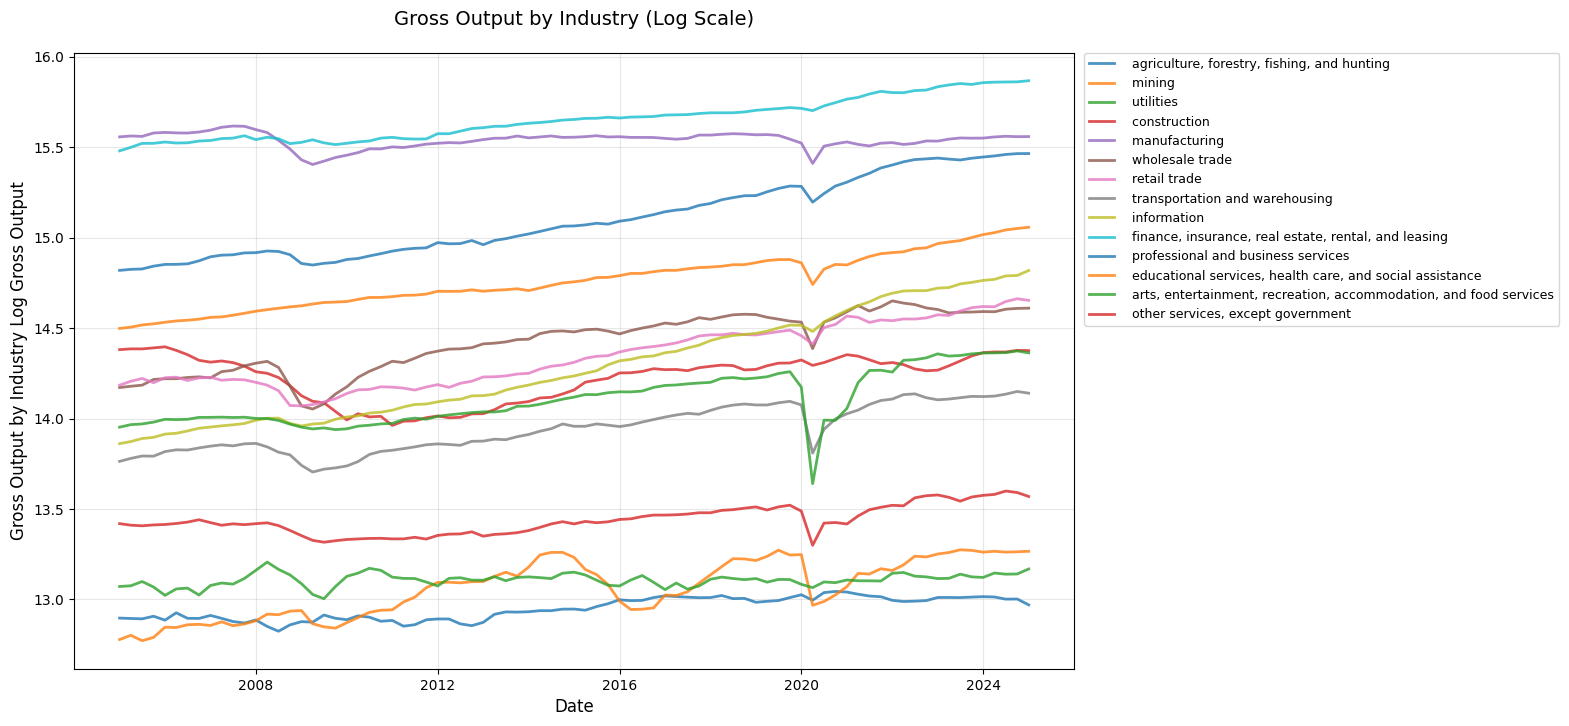

In [47]:
class GDPDataLoader:
    def __init__(self, file_path, sheet_name, skiprows=7):
        """
        Initialize the GDP Data Loader.
        
        Parameters:
        -----------
        file_path : str
            Path to the Excel file
        sheet_name : str
            Name of the sheet to read
        skiprows : int
            Number of rows to skip when reading (default: 7)
        """
        self.file_path = file_path
        self.sheet_name = sheet_name
        self.skiprows = skiprows
        self.df = None
    
    def load_and_clean(self):
        """
        Load and clean the GDP data with all transformations.
        
        Returns:
        --------
        pd.DataFrame
            Cleaned and pivoted DataFrame
        """
        # Read the Excel file
        self.df = pd.read_excel(self.file_path, sheet_name=self.sheet_name, skiprows=self.skiprows)
        
        # Filter rows that begin with exactly 2 spaces
        self.df = self.df[self.df['Unnamed: 1'].str.match(r'^  \S', na=False)]
        
        # Reset the index
        self.df = self.df.reset_index(drop=True)
        
        # Find and delete the Federal row and everything after
        federal_idx = self.df[self.df['Unnamed: 1'].str.contains('Federal', na=False)].index[0]
        self.df = self.df.loc[:federal_idx - 1]
        
        # Reset index again
        self.df = self.df.reset_index(drop=True)
        
        # Clean up columns
        self.df = self.df.drop(columns=['Line', 'Unnamed: 2']).rename(columns={'Unnamed: 1': 'date'})
        
        # Pivot
        self.df = self.df.set_index('date').T
        
        # Lowercase column names
        self.df.columns = self.df.columns.str.lower()
        
        # Convert quarter dates to datetime
        self.df.index = pd.PeriodIndex(self.df.index, freq='Q').to_timestamp()
        
        # Convert all columns to numeric, coercing errors to NaN
        for col in self.df.columns:
            self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
        
        
        # Apply log transformation to all numeric columns
        self.df = self.df.apply(lambda x: np.log(x) if pd.api.types.is_numeric_dtype(x) else x)
        
        
        return self.df
    
    def get_data(self):
        """
        Get the cleaned DataFrame.
        
        Returns:
        --------
        pd.DataFrame
            The cleaned DataFrame (returns None if load_and_clean hasn't been called)
        """
        return self.df
    
    def plot(self, title='Time-Series by Industry'):
        """
        Plot all data series on top of each other.
        
        Parameters:
        -----------
        title : str
            Title for the plot (default: 'Gross Output by Industry')
            '(Log Scale)' will be automatically appended
        """
        import matplotlib.pyplot as plt
        
        if self.df is None:
            raise ValueError("No data to plot. Call load_and_clean() first.")
        
        # Plot all columns
        fig, ax = plt.subplots(figsize=(16, 8))
        for col in self.df.columns:
            ax.plot(self.df.index, self.df[col], label=col, alpha=0.8, linewidth=2)
        
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel(f'{title} Log Gross Output', fontsize=12)
        ax.set_title(f'{title} (Log Scale)', fontsize=14, pad=20)
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', frameon=True, 
                 fontsize=9, ncol=1, borderaxespad=0)
        ax.grid(True, alpha=0.3)
        
        # Adjust layout to prevent legend cutoff
        plt.subplots_adjust(right=0.75)
        plt.show()


loader = GDPDataLoader(
file_path='../data/GdpByInd/GrossOutput.xlsx',
sheet_name='TGO106-Q'
)
gdp = loader.load_and_clean()

loader.plot(title='Gross Output by Industry')

In [40]:
gdp.head()

date,"agriculture, forestry, fishing, and hunting",mining,utilities,construction,manufacturing,wholesale trade,retail trade,transportation and warehousing,information,"finance, insurance, real estate, rental, and leasing",professional and business services,"educational services, health care, and social assistance","arts, entertainment, recreation, accommodation, and food services","other services, except government"
2005-01-01,12.897020,12.778582,13.071617,14.380822,15.556760,14.171395,14.184288,13.763158,13.861188,15.479427,14.818886,14.497999,13.952199,13.419040
2005-04-01,12.894798,12.801963,13.075509,14.385002,15.561770,14.178271,14.205991,13.779581,13.872730,15.498928,14.824464,14.505180,13.966278,13.410589
2005-07-01,12.892764,12.771898,13.099037,14.384825,15.559234,14.184489,14.221538,13.792814,13.889638,15.520841,14.826648,14.517182,13.970032,13.407038
2005-10-01,12.907208,12.790086,13.068674,14.390474,15.578105,14.216071,14.198062,13.792018,13.895951,15.521044,14.842262,14.523536,13.980199,13.411970
2006-01-01,12.885537,12.846963,13.022583,14.396244,15.581481,14.220064,14.225447,13.817253,13.914026,15.528300,14.851755,14.532092,13.995891,13.414336


In [20]:
loader = GDPDataLoader(
file_path='../data/GdpByInd/IntermediateInputs.xlsx',
sheet_name='TII106-Q'
)
int = loader.load_and_clean()

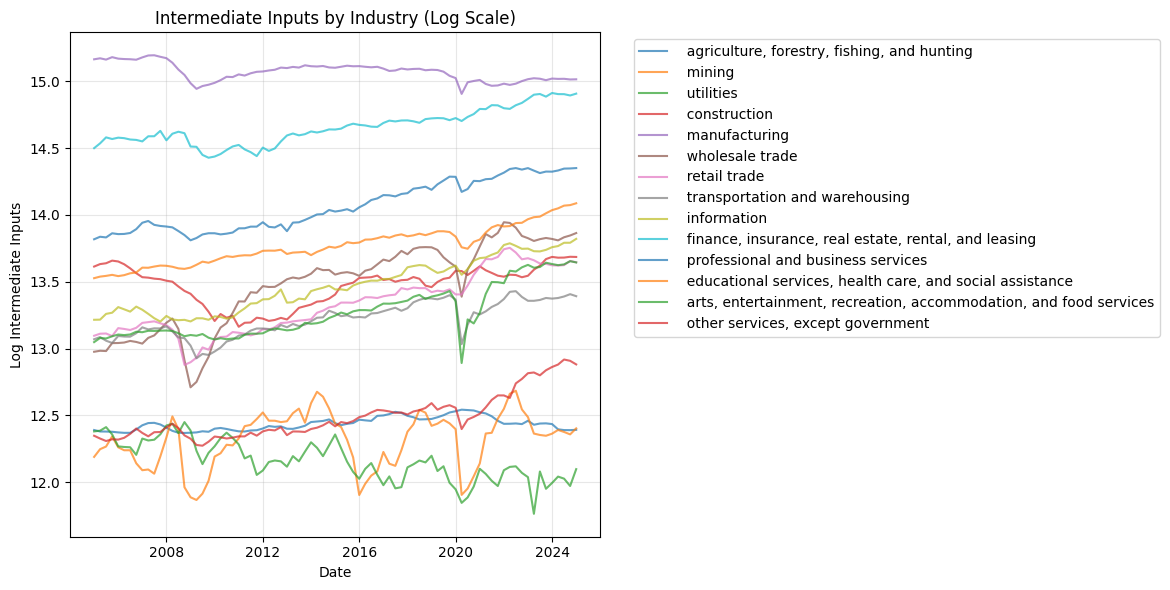

In [48]:
# Plot all columns
plt.figure(figsize=(12, 6))
for col in int.columns:
    plt.plot(int.index, int[col], label=col, alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Log Intermediate Inputs')
plt.title('Intermediate Inputs by Industry (Log Scale)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()